<a href="https://colab.research.google.com/github/julianmpratt/shockandtire/blob/main/Calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading...
From: https://drive.google.com/uc?id=16pTJwYs0wA6eq7pwwNuhUVq0-EUYdTo8
To: /content/snowshoecsv.csv
100%|██████████| 11.8k/11.8k [00:00<00:00, 24.6MB/s]


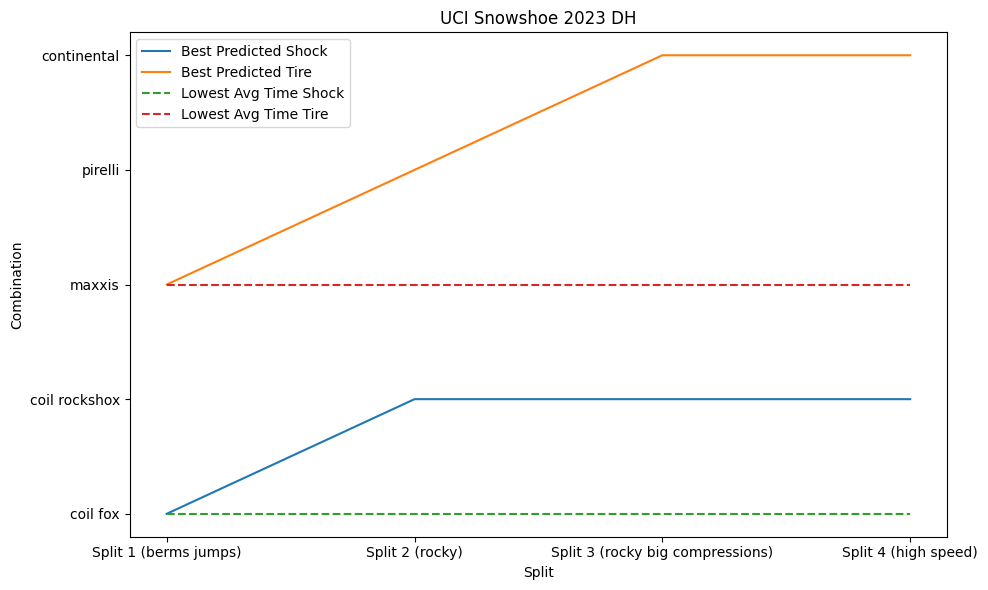

Enter your riding weight in pounds (including riding kit): 
150
Enter your bike's travel in millimeters: 
170
Enter your shock's stroke length in millimeters: 
65
Enter the percentage sag you want (e.g. 0.3 for 30% sag): 
0.3
What type of riding do you prefer (rocky, jumps, high speed, rocky big compressions)? 
rocky

The calculated spring rate is: 332.15 lb/in
We recommend a coil FOX for your preferred riding type.


In [ ]:
import pandas as pd
import gdown
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

def recommend_coil(riding_type):
    if riding_type.lower() == 'rocky':
        return 'coil FOX'
    elif riding_type.lower() == 'jumps':
        return 'coil ROCKSHOX'
    elif riding_type.lower() == 'high speed':
        return 'coil OHLINS'
    elif riding_type.lower() == 'rocky big compressions':
        return 'coil FOX'  # You can adjust this recommendation based on your specific knowledge or data

def calculate_spring_rate():
    # Load the data
    # Download the file from Google Drive
    url = 'https://drive.google.com/uc?id=16pTJwYs0wA6eq7pwwNuhUVq0-EUYdTo8'
    output = 'snowshoecsv.csv'
    gdown.download(url, output, quiet=False)

    # Load the data into a DataFrame
    data = pd.read_csv(output)

    # Remove leading and trailing whitespaces from column names
    data.columns = data.columns.str.strip()

    # Drop unnamed columns
    data.drop(data.columns[data.columns.str.contains('Unnamed', case=False)], axis=1, inplace=True)

    # Preprocess the data
    # Assuming 'Split 1' to 'Split 4' are the split time columns
    splits = ['Split 1 (berms jumps)', 'Split 2 (rocky)', 'Split 3 (rocky big compressions)', 'Split 4 (high speed)']

    # Handle missing values for 'Shock' column
    imputer_shock = SimpleImputer(strategy='most_frequent')
    data[['Shock']] = imputer_shock.fit_transform(data[['Shock']])

    # Handle missing values for 'Tires' column
    imputer_tires = SimpleImputer(strategy='most_frequent')
    data[['Tires']] = imputer_tires.fit_transform(data[['Tires']])

    # Standardize the values in the 'Shock' and 'Tires' columns
    data['Shock'] = data['Shock'].str.strip().str.lower()
    data['Tires'] = data['Tires'].str.strip().str.lower()

    # Encode categorical variables using one-hot encoding
    encoder = OneHotEncoder()
    encoded_columns = encoder.fit_transform(data[['Shock', 'Tires']]).toarray()

    # Create feature names for encoded columns
    shock_categories = encoder.categories_[0]
    tires_categories = encoder.categories_[1]
    encoded_feature_names = list(shock_categories) + list(tires_categories)

    # Concatenate the encoded columns with the original DataFrame
    encoded_df = pd.DataFrame(encoded_columns, columns=encoded_feature_names)
    data_encoded = pd.concat([data, encoded_df], axis=1)

    # Store the best shock and tire combination for each split
    best_shocks = {}
    best_tires = {}

    # Train a predictive model for each split
    for split in splits:
        # Define features and target
        X = data_encoded[encoded_feature_names]
        y = data_encoded[split]

        # Drop rows with missing values in both X and y
        data_dropna = pd.concat([X, y], axis=1).dropna()
        X = data_dropna[encoded_feature_names]
        y = data_dropna[split]

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Handle missing values in the features
        imputer_features = SimpleImputer(strategy='mean')
        X_train = imputer_features.fit_transform(X_train)
        X_test = imputer_features.transform(X_test)

        # Train a Random Forest Regressor model
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        # Find the shock and tire combination that resulted in the lowest time
        best_idx = model.predict(X_test).argmin()
        best_shocks[split] = data.loc[best_idx, 'Shock']
        best_tires[split] = data.loc[best_idx, 'Tires']

    # Find the shock and tire combination with the lowest average time across all splits
    lowest_avg_time_shock = data['Shock'].value_counts().idxmax()
    lowest_avg_time_tire = data['Tires'].value_counts().idxmax()

    # Plot the best shock and tire combination for each split
    plt.figure(figsize=(10, 6))
    plt.plot(splits, [best_shocks[split] for split in splits], label='Best Predicted Shock')
    plt.plot(splits, [best_tires[split] for split in splits], label='Best Predicted Tire')
    plt.plot(splits, [lowest_avg_time_shock] * len(splits), label='Lowest Avg Time Shock', linestyle='--')
    plt.plot(splits, [lowest_avg_time_tire] * len(splits), label='Lowest Avg Time Tire', linestyle='--')
    plt.xlabel('Split')
    plt.ylabel('Combination')
    plt.title('UCI Snowshoe 2023 DH')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate spring rate
    print("Enter your riding weight in pounds (including riding kit): ")
    weight = float(input())
    print("Enter your bike's travel in millimeters: ")
    travel = float(input())
    print("Enter your shock's stroke length in millimeters: ")
    shock_stroke = float(input())
    print("Enter the percentage sag you want (e.g. 0.3 for 30% sag): ")
    sag_percentage = float(input())

    weight_bias = 0.65  # Default weight bias

    # Convert travel and shock_stroke to inches
    travel_inch = travel / 25.4
    shock_stroke_inch = shock_stroke / 25.4

    # Calculate spring rate
    spring_rate = weight * weight_bias * (travel_inch / shock_stroke_inch) ** 2 / (travel_inch * sag_percentage)

    # Prompt the user for their preferred riding type
    print("What type of riding do you prefer (rocky, jumps, high speed, rocky big compressions)? ")
    riding_type = input()

    # Recommend a coil based on the user's riding type
    recommended_coil = recommend_coil(riding_type)

    # Output the results
    print(f"\nThe calculated spring rate is: {spring_rate:.2f} lb/in")
    print(f"We recommend a {recommended_coil} for your preferred riding type.")

# Call the function to run the calculator
calculate_spring_rate()
